In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats


In [ ]:
import seaborn as sns

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
import seaborn as sns

In [ ]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted',font_scale=1.5)

In [ ]:
RANDOM_SEED = 42

In [ ]:
#columns = ['user','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('drive/My Drive/AU_combined.csv', ' ')
df = df.dropna()
df.head()
print(df)

            accX      accY      accZ  ...     gyroZ     timestamp  Activity
0       0.000000  0.000000  0.000000  ... -0.010319  17:53:58.228        SS
1       0.000000  0.000000  0.000000  ...  0.012894  17:53:58.240        SS
2       0.000000  0.000000  0.000000  ...  0.031831  17:53:58.260        SS
3       0.000000  0.000000  0.000000  ...  0.072148  17:53:58.280        SS
4       0.000000  0.000000  0.000000  ...  0.092917  17:53:58.300        SS
...          ...       ...       ...  ...       ...           ...       ...
193791  0.500403  3.268185  8.174054  ... -0.083623  18:22:31.563        NS
193792  0.500403  3.268185  8.174054  ... -0.086677  18:22:31.568        NS
193793  0.500403  3.268185  8.174054  ... -0.115388  18:22:31.573        NS
193794  0.500403  3.268185  8.174054  ... -0.147763  18:22:31.593        NS
193795  0.500403  3.268185  8.174054  ... -0.142266  18:22:31.612        NS

[193796 rows x 8 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193796 entries, 0 to 193795
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   accX       193796 non-null  float64
 1   accY       193796 non-null  float64
 2   accZ       193796 non-null  float64
 3   gyroX      193796 non-null  float64
 4   gyroY      193796 non-null  float64
 5   gyroZ      193796 non-null  float64
 6   timestamp  193796 non-null  object 
 7   Activity   193796 non-null  object 
dtypes: float64(6), object(2)
memory usage: 13.3+ MB


In [ ]:
countOfActivity = df['Activity'].value_counts()
print(countOfActivity)

LS    64879
SS    64711
NS    64206
Name: Activity, dtype: int64


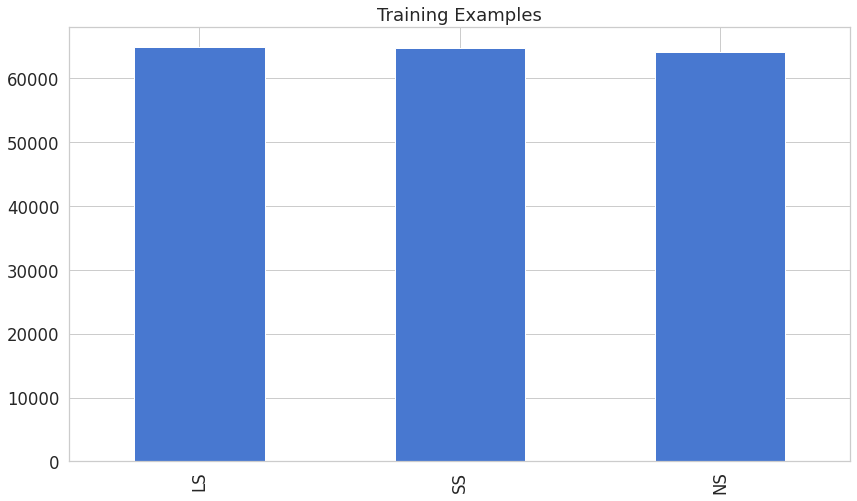

In [ ]:
countOfActivity.plot(kind='bar', title='Training Examples', figsize=(14,8));

In [ ]:
def plot_activity(activity,df):
    extractRowsOfActivity = (df['Activity'] == activity)
    data = df[extractRowsOfActivity]
    data = data[['accX', 'accY', 'accZ']]
    data = data[:200]
    
    ax = data.plot(subplots=True,figsize=(30,20),title=activity)

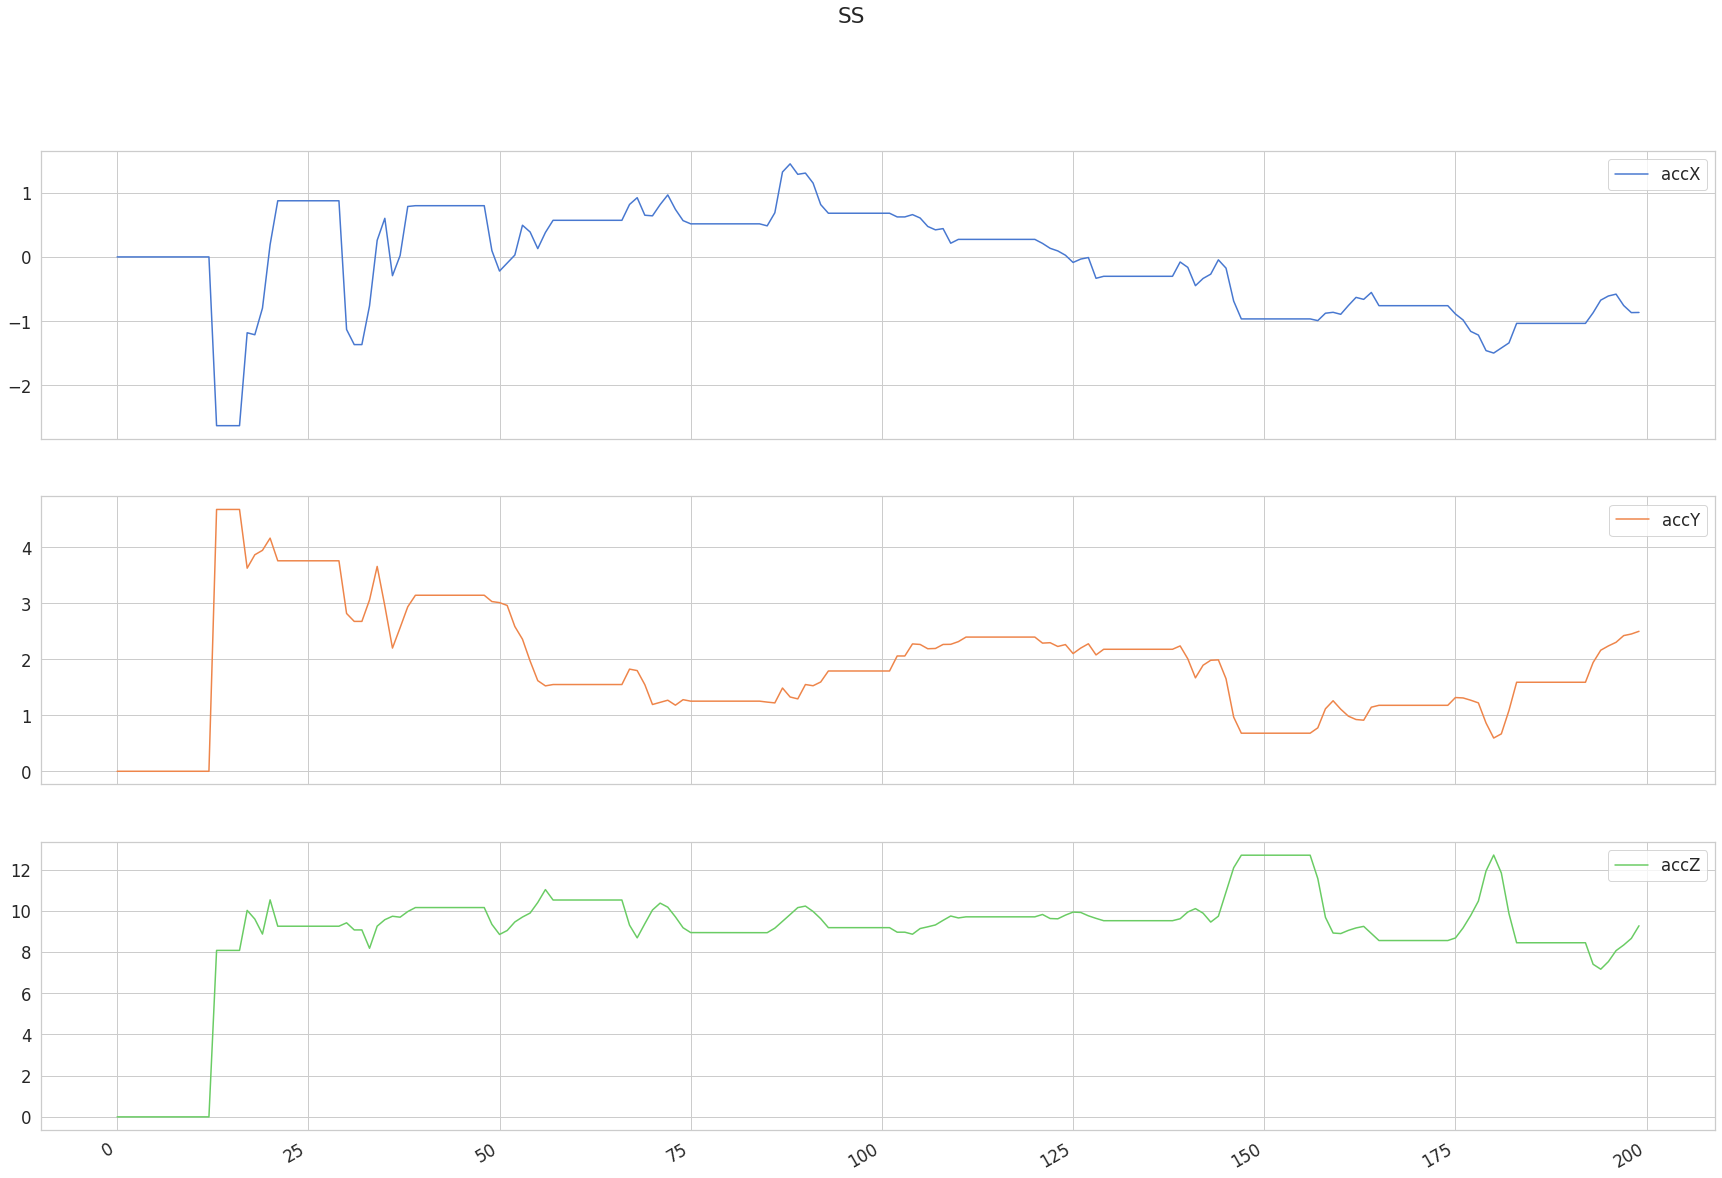

In [ ]:
plot_activity("SS",df)

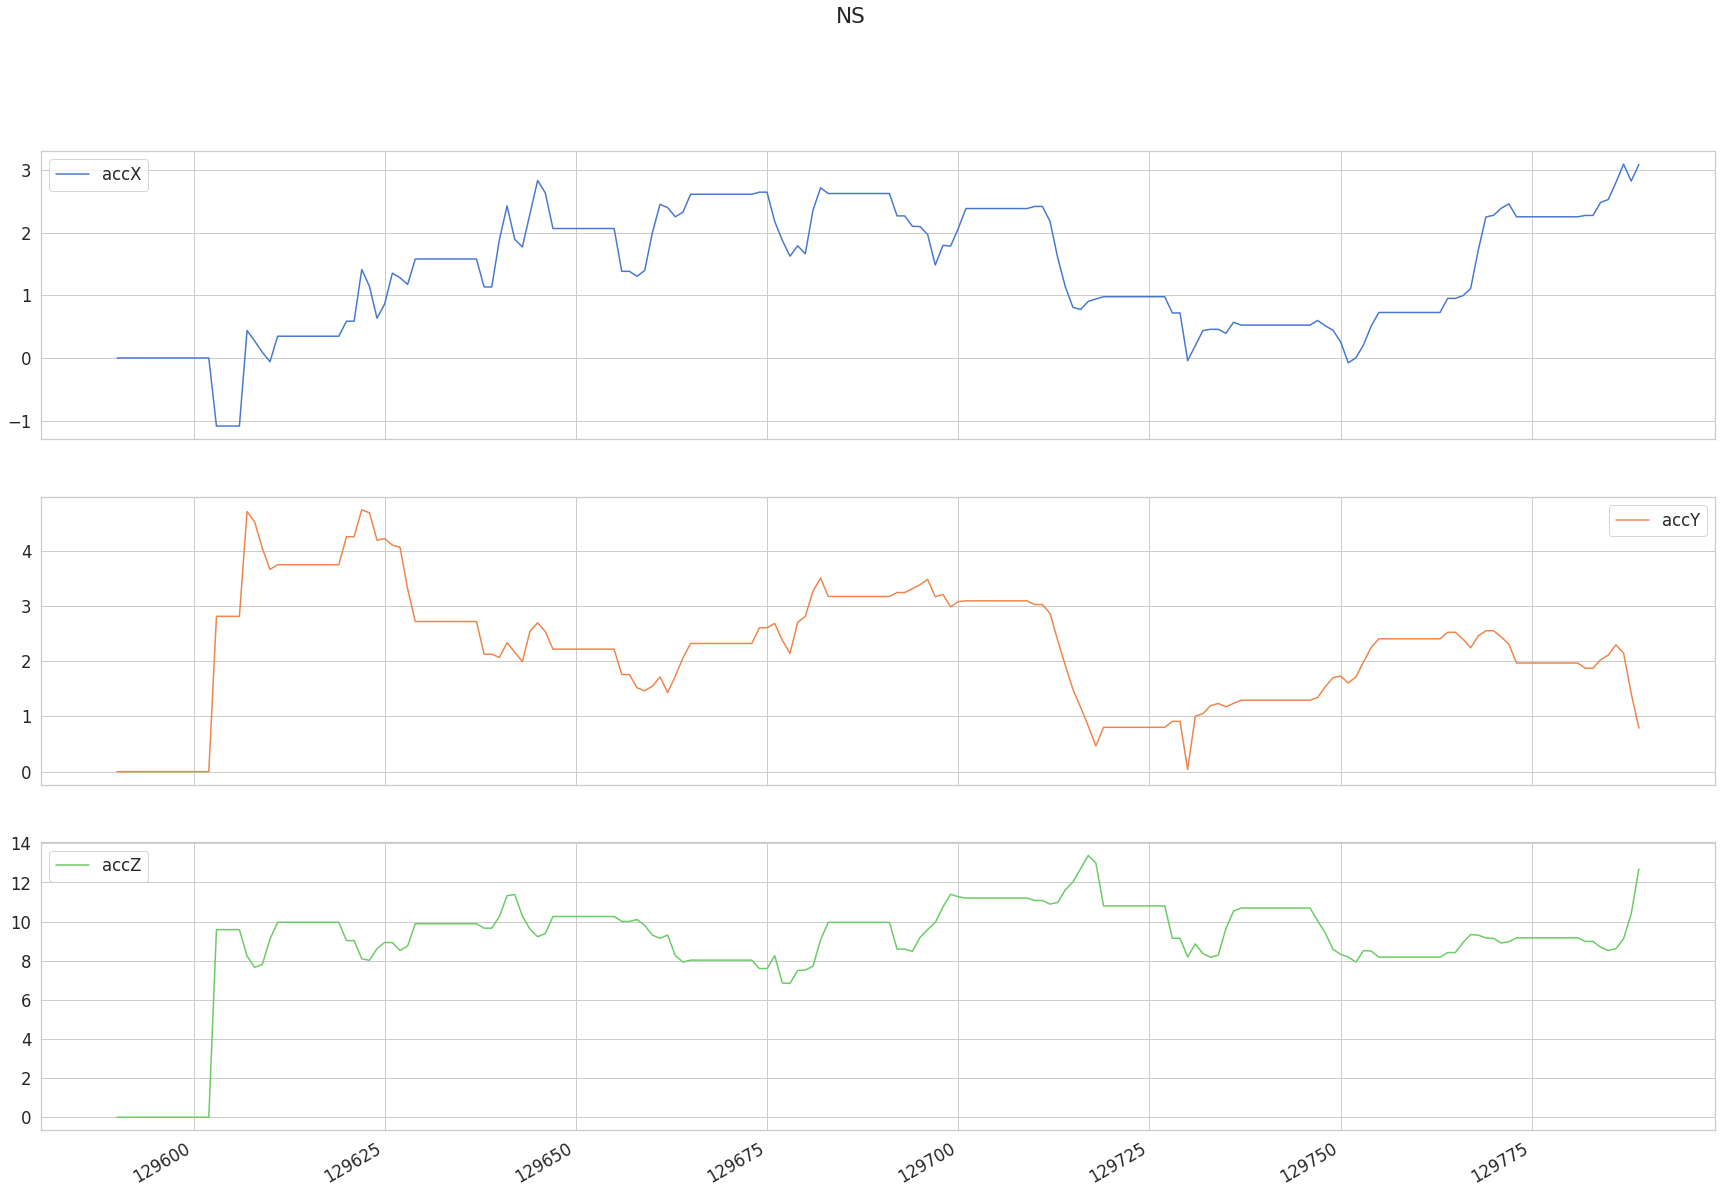

In [ ]:
plot_activity("NS",df)

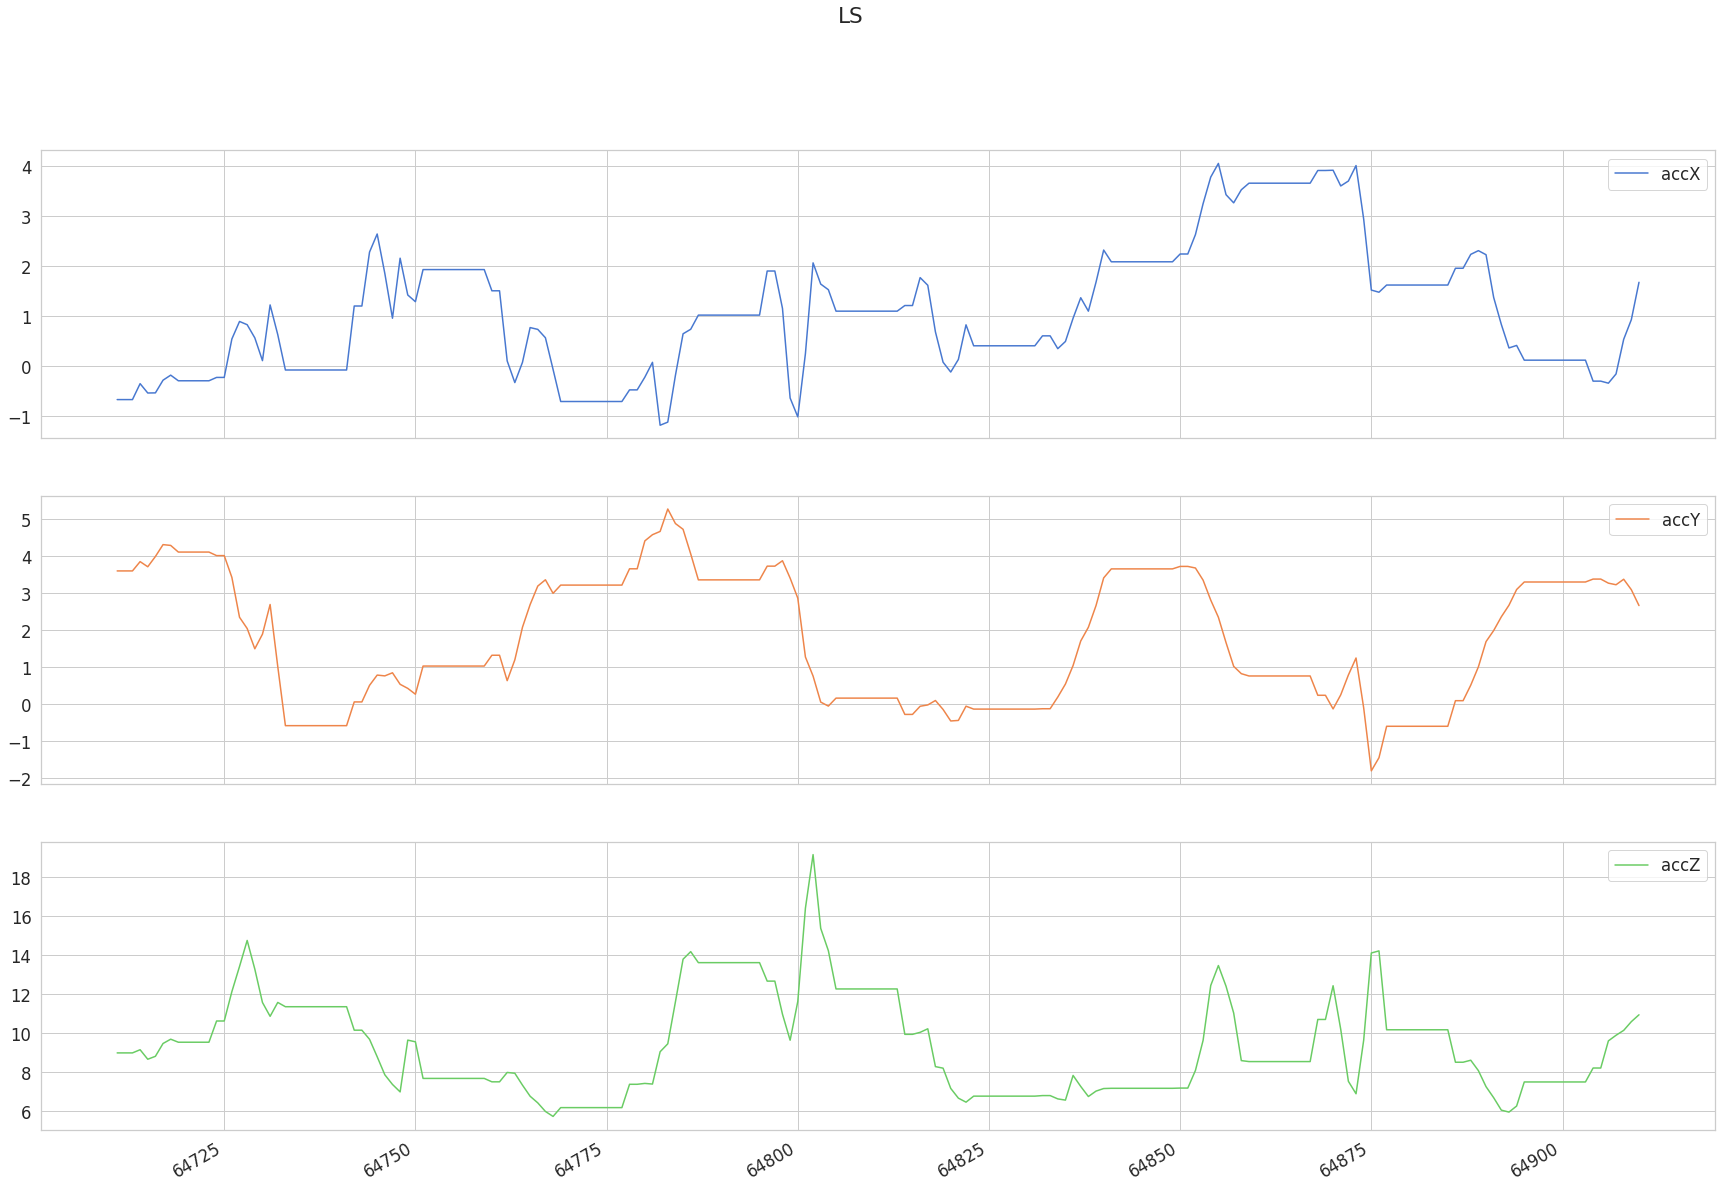

In [ ]:
plot_activity("LS",df)


In [ ]:
#Preprocessing
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['accX'].values[i: i + N_TIME_STEPS]
    ys = df['accY'].values[i: i + N_TIME_STEPS]
    zs = df['accZ'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])
    label = label[0][0]
    segments.append([xs,ys,zs])
    labels.append(label)

In [ ]:

np.array(segments).shape


(9680, 3, 200)

In [ ]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshaped_segments.shape

(9680, 200, 3)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [ ]:
print(labels)
print(labels.shape)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
(9680, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)

In [ ]:
len(X_train)

7744

In [ ]:
len(X_test)

1936

In [ ]:
#LSTM Model
N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [ ]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random.normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random.normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)
    
    #stack 2 LSTM layers
    lstm_layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_layers)
    
    #lstm_layers = [tf.keras.layers.LSTMCell(N_HIDDEN_UNITS) for _ in range(2)]
    #rnn = tf.keras.layers.StackedRNNCells(lstm_layers)
    
    outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    lstm_last_output = outputs[-1]
    #c = tf.Variable(tf.random.normal([step, N_CLASSES]), dtype=tf.float32)
    #lstm_last_output = rnn.get_initial_state(c)
    
    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [ ]:


tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.compat.v1.placeholder(tf.float32, [None, N_CLASSES])






In [ ]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [ ]:
L2_LOSS = 0.0015
l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [ ]:
LEARNING_RATE = 0.004

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [ ]:
#TRAINING
N_EPOCHS = 40
BATCH_SIZE = 140


In [ ]:
saver = tf.compat.v1.train.Saver()

history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])

sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})
    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_train, Y: y_train})
    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
        
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'Final Results: Accuracy: {acc_final} Loss: {loss_final}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 1 test accuracy: 0.6895661354064941 loss: 1.0384877920150757
epoch: 2 test accuracy: 0.9101239442825317 loss: 0.7364690899848938
epoch: 3 test accuracy: 0.9354338645935059 loss: 0.6179511547088623
epoch: 4 test accuracy: 0.9395661354064941 loss: 0.5829634666442871
epoch: 5 test accuracy: 0.9313016533851624 loss: 0.581084668636322
epoch: 6 test accuracy: 0.9266529083251953 loss: 0.5589260458946228
epoch: 7 test accuracy: 0.9560950398445129 loss: 0.4681117534637451
epoch: 8 test accuracy: 0.9452479481697083 loss: 0.4703346788883209
epoch: 9 test accuracy: 0.9395661354064941 loss: 0.4675979018211365
epoch: 10 test accuracy: 0.9395661354064941 loss: 0.4601444602012634
epoch: 11 test accuracy: 0.9405992031097412 loss: 0.4441957473754883
epoch: 12 test accuracy: 0.9478305578231812 loss: 0.4150223731994629
epoch: 13 test accuracy: 0.9550619721412659 loss: 0.37058085203170776
epoch: 14 test accuracy: 0.9550619721412659 loss: 0.355732798576355
epoch: 15 test accuracy: 0.9555785059928894 

In [ ]:

pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.compat.v1.train.write_graph(sess.graph_def, '.', 'har.pbtxt')
saver.save(sess, save_path = "har.ckpt")

from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework import graph_util
from tensorflow.python.tools import optimize_for_inference_lib

graph = tf.compat.v1.get_default_graph()
input_graph_def = graph.as_graph_def()
output_node_names = ['y_']

output_graph_def = tf.compat.v1.graph_util.convert_variables_to_constants(sess, input_graph_def, output_node_names)

with tf.compat.v1.gfile.GFile('frozen_har.pb', 'wb') as f:
    f.write(output_graph_def.SerializeToString())

    
input_graph_def_2 = tf.compat.v1.GraphDef()
with tf.compat.v1.gfile.Open('frozen_har.pb', "rb") as f:
    data = f.read()
    input_graph_def_2.ParseFromString(data)
    
output_graph_def_2 = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def_2,
        ["input"],
        ["y_"],
        tf.float32.as_datatype_enum)

f = tf.compat.v1.gfile.FastGFile("optimized_har.pb","wb")
f.write(output_graph_def_2.SerializeToString())

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
Instructions for updating:
Use tf.gfile.GFile.


In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


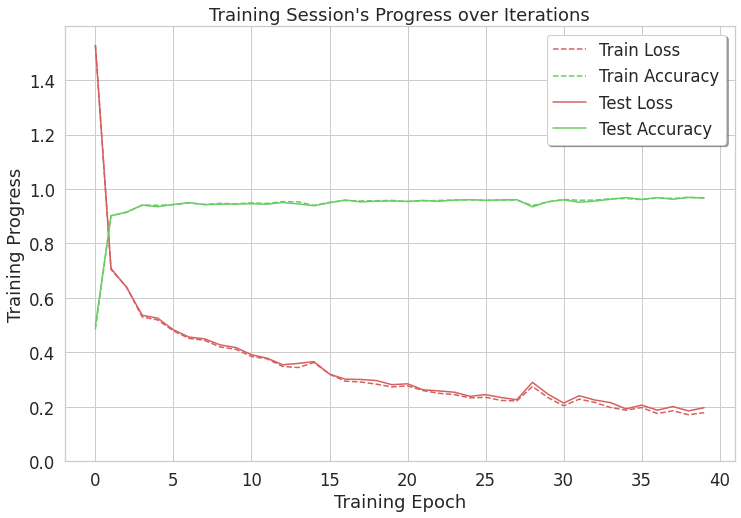

In [ ]:

plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train Loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train Accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test Loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test Accuracy")

plt.title("Training Session's Progress over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

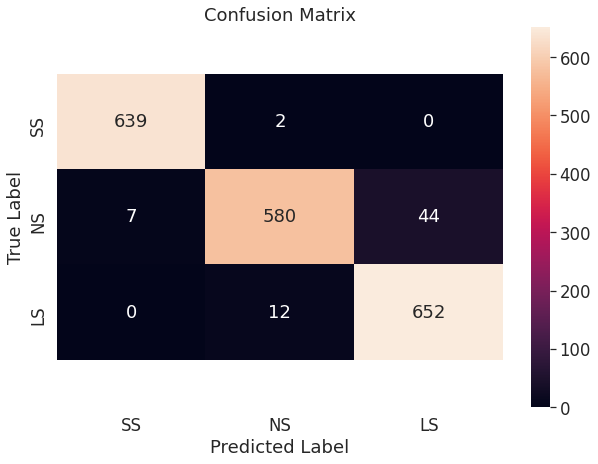

In [ ]:

LABELS = ['SS', 'NS', 'LS']

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
fig = plt.figure(figsize=(10,7))
ax = sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show();



In [ ]:
pd.crosstab(max_test, max_predictions, rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())



Predicted,0,1,2
True,,,
0,98.916409,0.336700,0.000000
1,1.083591,97.643098,6.321839
2,0.000000,2.020202,93.678161


In [ ]:
print(labels[1])

[0. 0. 1.]


In [ ]:
x = int(139.9)
print(x)

139
